In [10]:
import pandas as pd
import os
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# Specifying the filepath for the raw data and the cleaned file
path_raw = "../data/meters/raw/"
path_cleaned = "../data/meters/cleaned/"

In [3]:
# Files in directory
files = glob(path_raw + "*.csv")
files

['../data/meters/raw/hotwater.csv',
 '../data/meters/raw/gas.csv',
 '../data/meters/raw/solar.csv',
 '../data/meters/raw/electricity.csv',
 '../data/meters/raw/water.csv',
 '../data/meters/raw/chilledwater.csv',
 '../data/meters/raw/irrigation.csv',
 '../data/meters/raw/steam.csv']

In [ ]:
""" # Wrangling the data in a manner that concats all the above files pivots it into a usable format 

# Initialize list to store all the data frames 
dfs = []  

for file in files:  
    # Get meter type from filename
    meter_type = file.split("/")[-1].split(".")[0] 
    # file.split("/")[-1]: Splits the path by / and selects the last element (the full filename).
    # .split(".")[0]: Splits that filename by . and selects the first element (the part before the first dot)

    # Reading each file into a DataFrame
    file_path = file
    meter = pd.read_csv(file_path)
    
    # Pivoting the dataset 
    meter = pd.melt(meter, id_vars="timestamp", var_name="building_id", value_name="meter_reading")
    meter["meter"] = meter_type  
    dfs.append(meter) 

# Concatenate all DataFrames in the list into one DataFrame
combined_df = pd.concat(dfs, axis=0, ignore_index=True)

# Inspecting the dataset 
combined_df.sample(5) """

In [ ]:
# Wrangling the data in a manner that concats all the above files pivots it into a usable format 

# Initialize list to store all the data frames 
dfs = []  

for file in files:  
    # Get meter type from filename
    meter_type = file.split("/")[-1].split(".")[0] 
    # file.split("/")[-1]: Splits the path by / and selects the last element (the full filename).
    # .split(".")[0]: Splits that filename by . and selects the first element (the part before the first dot)

    # Reading each file into a DataFrame
    file_path = file
    meter = pd.read_csv(file_path)
    
    # Create a copy to avoid modifying the original 'meter' DataFrame if needed elsewhere
    meter_long = meter.set_index("timestamp").stack().reset_index()

    # Rename the automatically generated columns to match the original code's names
    meter_long.rename(
    columns={
        "level_1": "building_id",
        0: "meter_reading",  # The 'stack()' method uses 0 as a default name
    },
    inplace=True,
    )
    # Add the 'meter' type column
    meter_long["meter"] = meter_type
  
    # Append the resulting DataFrame to the list
    dfs.append(meter_long)
    
# Concatenate all DataFrames in the list into one DataFrame
combined_df = pd.concat(dfs, axis=0, ignore_index=True)

# Inspecting the dataset 
combined_df.sample(5)

In [5]:
# Display basic info
print(f"Total records: {len(combined_df)}")
print(f"Columns: {combined_df.columns.tolist()}")
print("\nFirst few rows:")
print(combined_df.head())
print("\nData types:")
print(combined_df.dtypes)
print("\nMissing values:")
print(combined_df.isnull().sum())

# Optionally save the combined dataframe
# combined_df.to_csv("../data/meter/processed/combined_meter_data.csv", index=False)

Total records: 50302251
Columns: ['timestamp', 'building_id', 'meter_reading', 'meter']

First few rows:
             timestamp             building_id  meter_reading     meter
0  2016-01-01 00:00:00   Robin_public_Carolina         0.2421  hotwater
1  2016-01-01 00:00:00        Robin_office_Wai         0.0000  hotwater
2  2016-01-01 00:00:00      Robin_office_Zelma         0.0000  hotwater
3  2016-01-01 00:00:00    Robin_office_Lindsay         9.7989  hotwater
4  2016-01-01 00:00:00  Robin_education_Derick       299.7292  hotwater

Data types:
timestamp         object
building_id       object
meter_reading    float64
meter             object
dtype: object

Missing values:
timestamp        0
building_id      0
meter_reading    0
meter            0
dtype: int64


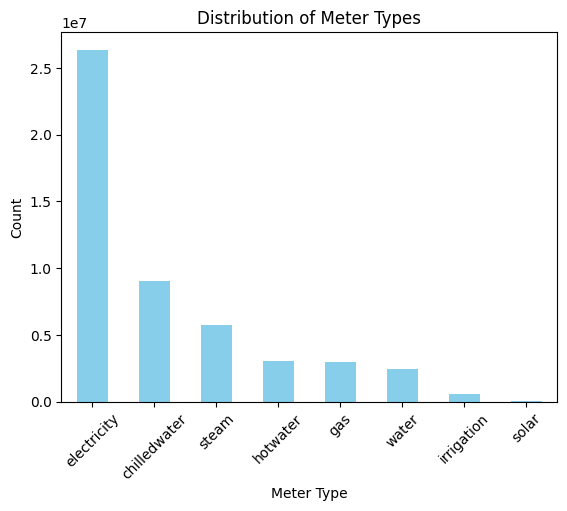

In [6]:
# Check the meter counts 
meter_counts = combined_df["meter"].value_counts()

# Plot the results
meter_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Meter Types')
plt.xlabel('Meter Type')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()

In [7]:
combined_df["meter"].value_counts()

meter
electricity     26372337
chilledwater     9060408
steam            5760415
hotwater         3044380
gas              3001658
water            2413296
irrigation        579693
solar              70064
Name: count, dtype: int64

In [12]:
# Check number of buildings for which the data is recorded 
len(np.unique(combined_df["building_id"]))

1634

In [13]:
# Rounds meter reading to to 4 decimals places 
combined_df["meter_reading"] = round(combined_df["meter_reading"],4)

# Inspecting the Data Again
combined_df.sample(7)

,timestamp,building_id,meter_reading,meter
16366921,2016-10-13 01:00:00,Rat_education_Esther,63.8200,electricity
2226646,2017-06-25 00:00:00,Fox_education_Yolande,44663.1119,hotwater
10756813,2016-05-11 05:00:00,Hog_education_Roberto,128.0370,electricity
22632225,2017-04-04 23:00:00,Cockatoo_office_Elbert,21.8500,electricity
46622463,2016-09-29 19:00:00,Bull_assembly_Lance,73.4898,steam
19595894,2017-01-11 00:00:00,Moose_education_Leland,1533.5984,electricity
48400597,2017-05-10 11:00:00,Cockatoo_education_Christi,233.1413,steam


The dataset contains hourly meter readings for 2016–2017. The next step is to aggregate these to daily totals per building and meter type:

- Convert `timestamp` to datetime and extract the date (and year).
- Group by date, `building_id`, and `meter`, then compute the total of `meter_reading` to get total daily usage.
- Keep the year (2016 or 2017) so you can produce separate summaries or filter by year as needed.
- Save the resulting daily-averaged table to the cleaned data directory for downstream analysis.

In [17]:
# Aggregate hourly readings to daily totals per building and meter type
# Uses existing variables: combined_df (DataFrame) and path_cleaned (str)

# Ensure timestamp is datetime and drop rows where it cannot be parsed
combined_df["timestamp"] = pd.to_datetime(combined_df["timestamp"], errors="coerce")
combined_df = combined_df.dropna(subset=["timestamp"])

# Ensure date and year columns exist
combined_df["date"] = combined_df["timestamp"].dt.date
combined_df["year"] = combined_df["timestamp"].dt.year

# Group and compute daily total meter reading
daily_totals = (
    combined_df
    .groupby(["date", "building_id", "meter"], observed=True, as_index=False)["meter_reading"]
    .sum()
    .rename(columns={"meter_reading": "total_meter_reading"})
)


In [21]:
daily_totals.sort_values(by=["building_id", "meter", "date"], inplace=True)

In [22]:
daily_totals.head()

,date,building_id,meter,total_meter_reading
0,2016-01-01,Bear_assembly_Angel,electricity,12808.1620
2824,2016-01-02,Bear_assembly_Angel,electricity,9251.0003
5648,2016-01-03,Bear_assembly_Angel,electricity,14071.6500
8473,2016-01-04,Bear_assembly_Angel,electricity,12860.3758
11298,2016-01-05,Bear_assembly_Angel,electricity,12212.8585


In [ ]:
# Save to cleaned directory (compressed)
Path(path_cleaned).mkdir(parents=True, exist_ok=True)
out_path = Path(path_cleaned) / "daily_meter_totals_2016_2017.csv.gz"
daily_totals.to_csv(out_path, index=False, compression="gzip")

# Quick feedback
print(f"Saved daily totals to: {out_path} (rows: {len(daily_totals)})")
daily_totals.head()

- next create totals or averages for each year